In [12]:
# Import Modules/Libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms, models
from torch.utils.data import DataLoader, Dataset, random_split
import matplotlib
from matplotlib import pyplot as plt
import os
import glob
from PIL import Image
import numpy as np
import random
from tqdm import tqdm

In [14]:
# Import Libraries and Setup GPU Device
# Confirm GPU device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [15]:
# Data Preparation and Transformations
# Define the transformations for the dataset
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize images to 128x128
    transforms.RandomHorizontalFlip(p=0.5),  # Apply random horizontal flip
    transforms.RandomRotation(degrees=15),  # Apply random rotation within 15 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Randomly change brightness, contrast, etc.
    transforms.ToTensor(),          # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize the images
])

In [16]:
# Custom Dataset Class
# Create a custom dataset class to handle images without subfolders
class CatDogDataset(Dataset):
    def __init__(self, file_paths, transform=None):
        self.file_paths = file_paths
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        img_path = self.file_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = 0 if 'cat' in os.path.basename(img_path) else 1
        if self.transform:
            image = self.transform(image)
        return image, label

# Load all image paths from the 'dataset/train' directory
image_paths = glob.glob('dataset/train/*.jpg')

# Check if the dataset is loaded correctly
if len(image_paths) == 0:
    raise ValueError("No images found in the dataset/train directory. Please check the path and ensure images are available.")
else:
    print(f"Number of images found: {len(image_paths)}")

# Create dataset
full_dataset = CatDogDataset(image_paths, transform=transform)

# Split the dataset into 70% training and 30% testing
train_size = int(0.7 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

# Create DataLoaders for training and testing
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=0)

Number of images found: 25000


Loss plot saved as training_validation_loss.png


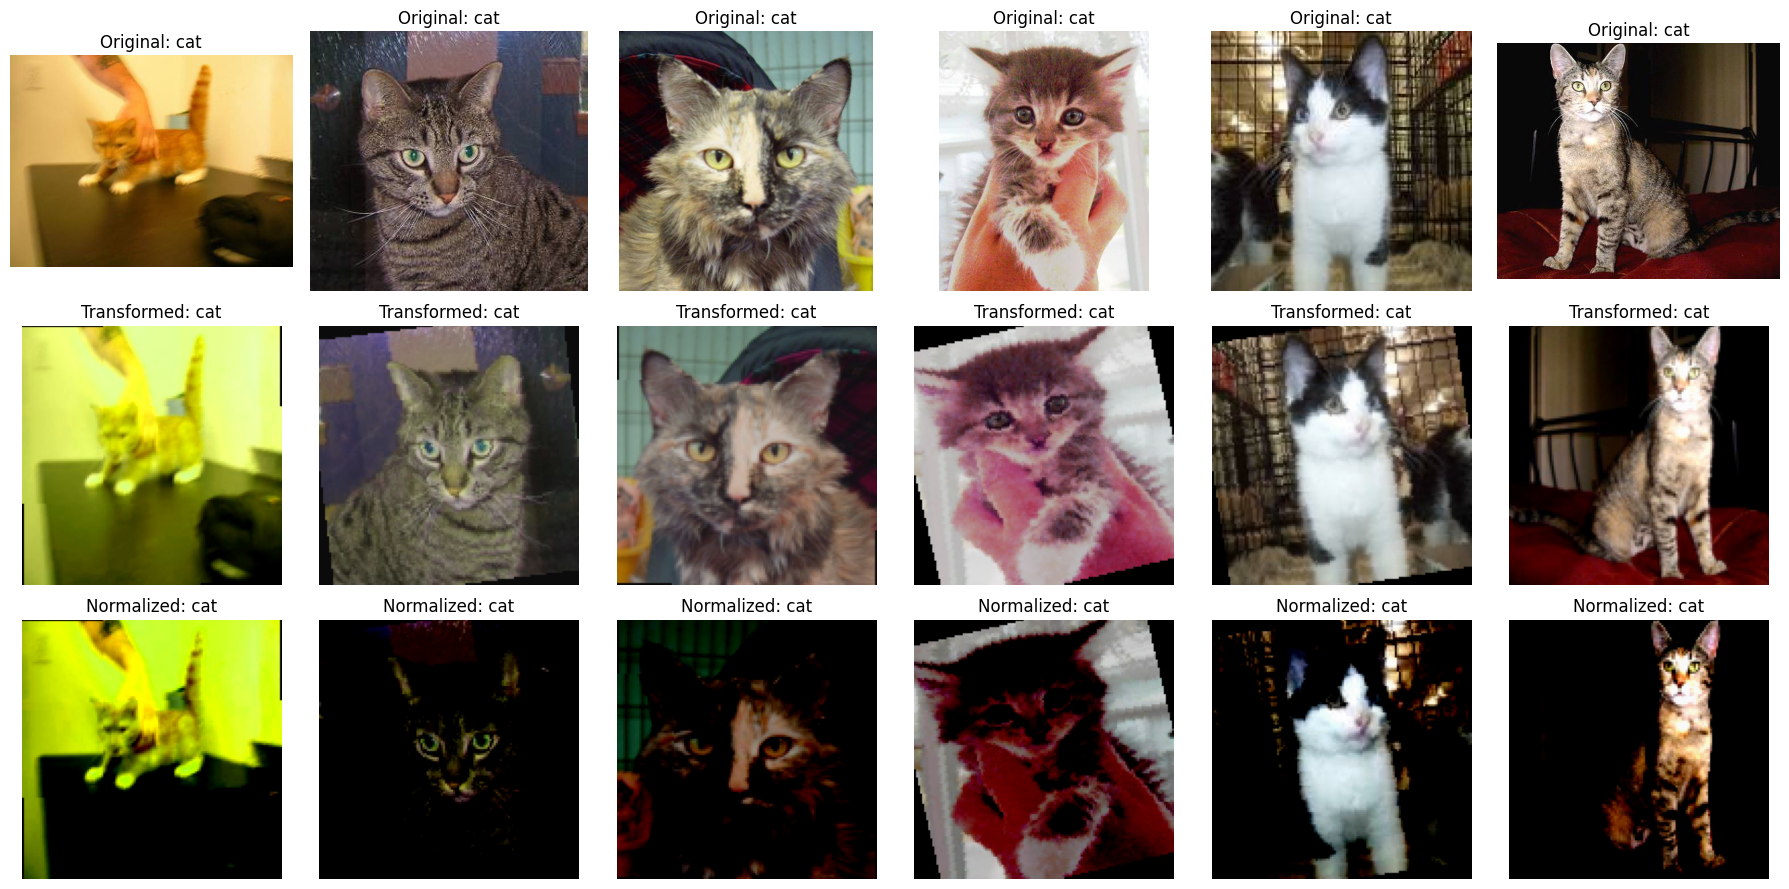

In [17]:
# Demonstrate Some Transformed Samples
# Display a few samples after transformations to verify the augmentation and normalization
def imshow(img, title=None):
    if img.min() < 0 or img.max() > 1:
        img = img / 2 + 0.5  # Unnormalize the image
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if title:
        plt.title(title)
    plt.savefig('training_validation_loss.png')
print('Loss plot saved as training_validation_loss.png')

# Get some random training images
sample_loader = DataLoader(train_dataset, batch_size=6, shuffle=True)
dataiter = iter(sample_loader)
images, labels = next(dataiter)

# Show 6 random images: original, transformed, and normalized
fig, axes = plt.subplots(3, 6, figsize=(18, 9))

# Ensure consistent image paths and transformations
for i in range(6):
    img_path = image_paths[i]
    
    # Load the original image
    original_img = Image.open(img_path).convert('RGB')
    axes[0, i].imshow(original_img)
    axes[0, i].set_title(f"Original: {'cat' if 'cat' in img_path else 'dog'}")
    axes[0, i].axis('off')
    
    # Apply the same transformation used for training
    if transform:
        transformed_img_tensor = transform(original_img)
    
    # Transformed image (after augmentation)
    transformed_img = transformed_img_tensor.permute(1, 2, 0).numpy() * 0.5 + 0.5  # Reverse normalization for visualization
    transformed_img = np.clip(transformed_img, 0, 1)  # Clip values to [0, 1] range
    axes[1, i].imshow(transformed_img)
    axes[1, i].set_title(f"Transformed: {'cat' if 'cat' in img_path else 'dog'}")
    axes[1, i].axis('off')
    
    # Normalized image
    normalized_img = transformed_img_tensor.permute(1, 2, 0).numpy()
    normalized_img = np.clip(normalized_img, 0, 1)  # Clip values to [0, 1] range
    axes[2, i].imshow(normalized_img)
    axes[2, i].set_title(f"Normalized: {'cat' if 'cat' in img_path else 'dog'}")
    axes[2, i].axis('off')

plt.tight_layout()
plt.show()

In [18]:
# Initialize Pre-trained Model
# Load a pre-trained VGG16 model and modify it for binary classification
model = models.vgg16(pretrained=True)
for param in model.features.parameters():
    param.requires_grad = False  # Freeze the feature extraction layers

# Modify the classifier to output 2 classes (cat and dog)
model.classifier[6] = nn.Linear(4096, 2)

# Move model to GPU if available
model = model.to(device)

In [19]:
# Loss and Optimizer Setup
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

In [20]:
# Training Loop
# Training loop with model checkpointing to prevent data loss in case of interruption

def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=10, checkpoint_path='models/checkpoint.pth'):
    model.train()
    train_losses, val_losses = [], []

    # Load checkpoint if available
    start_epoch = 0
    if os.path.exists(checkpoint_path):
        checkpoint = torch.load(checkpoint_path, weights_only=True)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch'] + 1
        train_losses = checkpoint['train_losses']
        val_losses = checkpoint['val_losses']
        print(f"Resuming training from epoch {start_epoch}")

    for epoch in range(start_epoch, num_epochs):
        running_loss = 0.0
        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        else:
            # Calculate average training loss
            train_losses.append(running_loss / len(train_loader))
            # Validate the model
            val_loss = validate_model(model, criterion, val_loader)
            val_losses.append(val_loss)

            # Print epoch details
            print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {running_loss/len(train_loader):.4f}, Validation Loss: {val_loss:.4f}")

            # Save checkpoint after each epoch
            if not os.path.exists(os.path.dirname(checkpoint_path)):
                os.makedirs(os.path.dirname(checkpoint_path))
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_losses': train_losses,
                'val_losses': val_losses
            }, checkpoint_path)

    return train_losses, val_losses

In [21]:
# Validation Loop
# Function to validate the model on the validation set

def validate_model(model, criterion, val_loader):
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc="Validation"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    return val_loss / len(val_loader)

In [22]:
# Training the Model
# Train the model and save progress periodically
train_losses, val_losses = train_model(model, criterion, optimizer, train_loader, test_loader, num_epochs=50)

Resuming training from epoch 50


Length of train_losses: 50
Length of val_losses: 50
train_losses: [0.39397623596617776, 0.13573233639128016, 0.12688395473426275, 0.11997677856226907, 0.1158763435771213, 0.1045019706425658, 0.09893223240862797, 0.1103657340889212, 0.12124869375605218, 0.09497612279697057, 0.08484597115294777, 0.0833969062778854, 0.07407490505299864, 0.0722866462217304, 0.07061617438049211, 0.07941785086299816, 0.06812796229156699, 0.061092805192146424, 0.05405897257618443, 0.05679304567403602, 0.048806871243337865, 0.04742802217956225, 0.04812005343405108, 0.0450109751371626, 0.04451586955981533, 0.0414167706698288, 0.04020384818070779, 0.04449543031442394, 0.04374575650278669, 0.03638127192865078, 0.04004907301443554, 0.035287949387459966, 0.033074141687366866, 0.032786374104406386, 0.03374185957979873, 0.03423418896952576, 0.033212062304526786, 0.031266402660522365, 0.029291189275681973, 0.026835183922310164, 0.03096918634778011, 0.02614029545768633, 0.027847301940617228, 0.032341597112317155, 0.026

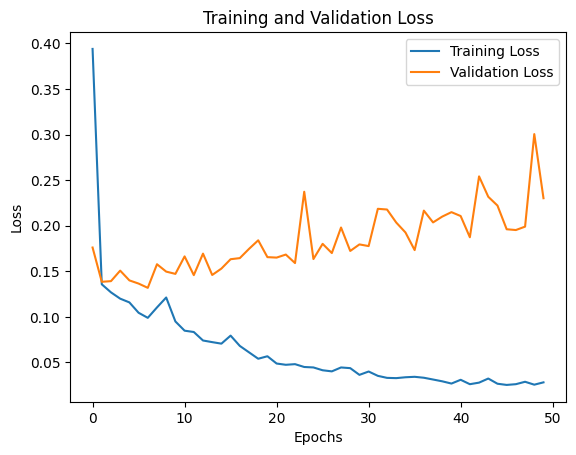

In [23]:
# Plotting Loss Curves
# Load checkpoint if available
checkpoint_path = 'models/checkpoint.pth'
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path, weights_only=False)  # Removed 'weights_only=True'
    train_losses = checkpoint.get('train_losses', [])
    val_losses = checkpoint.get('val_losses', [])
else:
    train_losses = []
    val_losses = []

# Check the length of losses and their contents
print(f"Length of train_losses: {len(train_losses)}")
print(f"Length of val_losses: {len(val_losses)}")
print(f"train_losses: {train_losses}")
print(f"val_losses: {val_losses}")

# Plot training and validation loss curves to visualize model performance
if len(train_losses) > 0 and len(val_losses) > 0:
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.savefig('figures/training_validation_loss.png')
    print('Loss plot saved as training_validation_loss.png')
else:
    print("No loss data to plot.")

In [12]:
# Save the Final Model
# Save the final trained model
if not os.path.exists('models'):
    os.makedirs('models')
torch.save(model.state_dict(), 'models/classifier_model.pth')

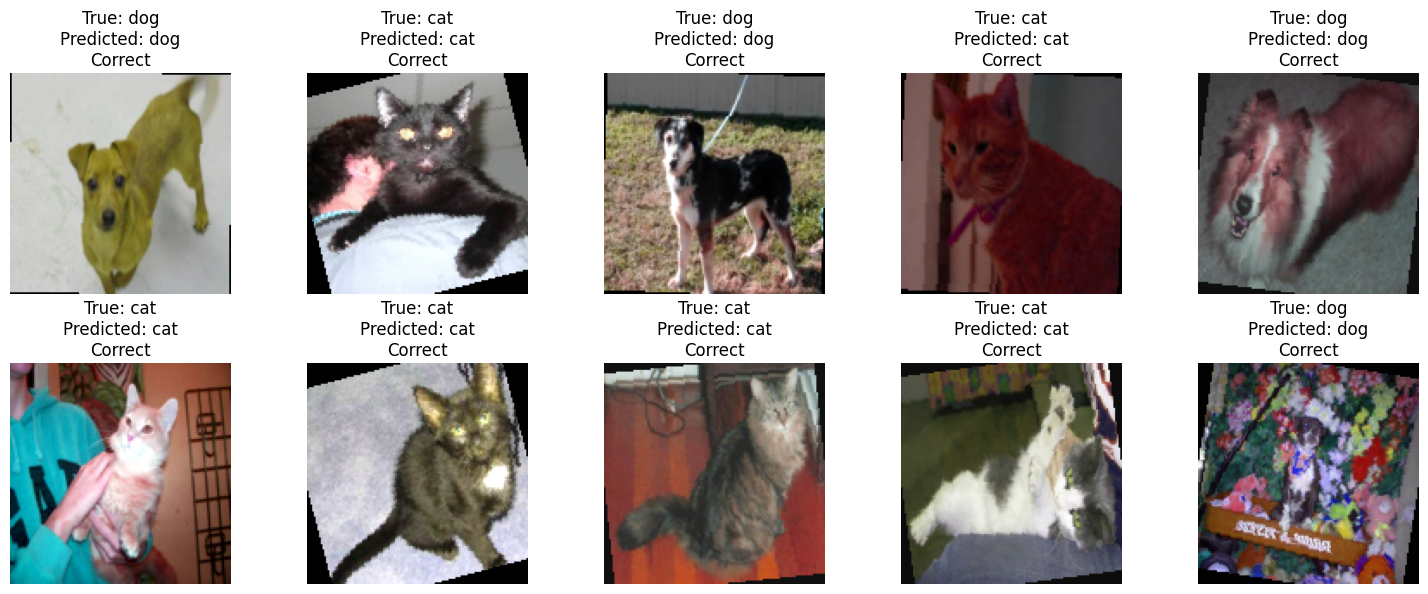

Correct Predictions: 10/10
Incorrect Predictions: 0/10


In [25]:
# Test the Model on Sample Images
# Evaluate the model's performance on randomly selected images from the validation set
def test_model_on_validation_samples(model, val_dataset, num_samples=10):
    model.eval()
    sample_indices = random.sample(range(len(val_dataset)), num_samples)
    correct_predictions = 0
    incorrect_predictions = 0
    results = []

    # Iterate over the selected images
    for idx in sample_indices:
        image, label = val_dataset[idx]
        image_tensor = image.unsqueeze(0).to(device)
        with torch.no_grad():
            output = model(image_tensor)
            _, predicted = torch.max(output, 1)
            predicted_label = 'cat' if predicted.item() == 0 else 'dog'
            true_label = 'cat' if label == 0 else 'dog'
            success = (predicted_label == true_label)
            if success:
                correct_predictions += 1
            else:
                incorrect_predictions += 1
            results.append((image, true_label, predicted_label, success))

    # Plotting results in a matrix format
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    axes = axes.flatten()
    for i, (image, true_label, predicted_label, success) in enumerate(results):
        image = image.permute(1, 2, 0).numpy() * 0.5 + 0.5  # Reverse normalization
        image = np.clip(image, 0, 1)
        axes[i].imshow(image)
        axes[i].set_title(f"True: {true_label}\nPredicted: {predicted_label}\n{'Correct' if success else 'Incorrect'}")
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

    # Summary of results
    print(f"Correct Predictions: {correct_predictions}/{num_samples}")
    print(f"Incorrect Predictions: {incorrect_predictions}/{num_samples}")

# Test the model on some sample validation images
test_model_on_validation_samples(model, test_dataset, num_samples=10)